# Applying [JAX](https://github.com/google/jax) to a model with realistic noise, continuum filtering and wavelength sampling.
Brett Morris & Jens Hoeijmakers


This is based on a fork of Brett's retrieval demo, applied to high resolution transmission spectra.

In [313]:
%matplotlib inline
# We need to import numpyro first, though we use it last
import numpyro
from numpyro.infer import MCMC, NUTS
from numpyro import distributions as dist
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
from jax import numpy as jnp
from jax import jit, partial
from jax.scipy.optimize import minimize
from jax.random import PRNGKey, split

import tayph.util as ut
import tayph.system_parameters as sp
import tayph.functions as fun
import tayph.util as ut
from tayph.vartests import typetest,notnegativetest,nantest,postest,typetest_array,dimtest
from tayph.vartests import lentest
import tayph.operations as ops
import tayph.masking as masking
import copy

from pathlib import Path

import arviz
from corner import corner

import astropy.io.fits as fits
import astropy.constants as const
import astropy.units as u

from collections import OrderedDict


cpu_cores = 4
numpyro.set_host_device_count(cpu_cores)



### Loading opacities.
Opacity functions of various species are located in the `opacity/` folder. We load them using a binary IO script packaged in `tayph`. We save each species in a species object, and keep track of those with a dictionary.

In [314]:
class species:#Species
  def __init__(self, label, tag):
    self.label = label
    self.tag = tag
    

labels = ['Ca', 'Ti', 'V', 'Cr', 'Fe']
tags = [2000,2200,2300,2400,2600]

labels=['Fe','Ti','V']
tags=[2600,2200,2300]
S = OrderedDict()#This will hold all my species objects.
for i in range(len(labels)):
    S[labels[i]] = species(labels[i],tags[i])

In [315]:
for i in list(S.keys()):
    S[i].path = ut.check_path(f'opacity/VALD_{S[i].tag}e2/Out_00000_60000_02500_n800.bin',exists=True)
    S[i].kappa = jnp.array(ut.read_binary_kitzmann(S[i].path,double=False))
    
k_wn = jnp.arange(len(S['Fe'].kappa))*1e-2#Wavenumbers
k_wl = 1e7/k_wn#Wavelength in nm; common to all the opacity functions.

To make a good choice about what to interpolate this onto, we first load in the data. This is copied out of tayph.

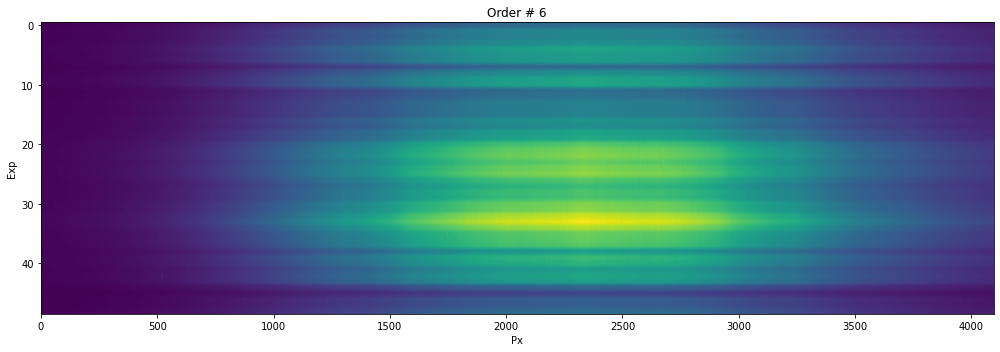

In [4]:
dp = ut.check_path('data/KELT-9/night1/',exists=True)#This follows the file structure of tayph.

air = sp.paramget('air',dp)
do_berv_correction = True
do_keplerian_correction = True

list_of_wls=[]#This will store all the data.
list_of_orders=[]#All of it needs to be loaded into your memory, more than once.
list_of_sigmas=[]#Hope that's ok...
n_negative_total = 0#This will hold the total number of pixels that were set to NaN because

filelist_orders= [str(i) for i in Path(dp).glob('order_*.fits')]
if len(filelist_orders) == 0:#If no order FITS files are found:
    raise Exception(f'Runtime error: No orders_*.fits files were found in {dp}.')
try:
    order_numbers = [int(i.split('order_')[1].split('.')[0]) for i in filelist_orders]
except:
    raise Exception('Runtime error: Failed at casting fits filename numerals to ints. Are the '
    'filenames of all of the spectral orders correctly formatted (e.g. order_5.fits)?')
order_numbers.sort()#This is the ordered list of numerical order IDs.
n_orders = len(order_numbers)


for i in order_numbers:
    wavepath = dp/f'wave_{i}.fits'
    orderpath= dp/f'order_{i}.fits'
    ut.check_path(wavepath,exists=True)
    ut.check_path(orderpath,exists=True)
    wave_order = ut.readfits(wavepath)#2D or 1D?
    order_i = ut.readfits(orderpath)

    #Check dimensionality of wave axis and order. Either 2D or 1D.
    if wave_order.ndim == 2:

        n_px = np.shape(wave_order)[1]#Pixel width of the spectral order.
        dimtest(wave_order,np.shape(order_i),'wave_order in tayph.run_instance()')
    elif wave_order.ndim == 1:
        n_px = len(wave_order)
        dimtest(order_i,[0,n_px],f'order {i} in run_instance()')
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    if i == np.min(order_numbers):
        n_exp = np.shape(order_i)[0]#For the first order, we fix n_exp.
    else:
        dimtest(order_i,[n_exp,n_px],f'order {i} in run_instance()')

    #Deal with air or vaccuum wavelengths:
    if air == False:
        list_of_wls.append(copy.deepcopy(wave_order))
    else:
        list_of_wls.append(ops.airtovac(wave_order))


    #Now test for negatives, set them to NaN and track them.
    n_negative = len(order_i[order_i <= 0])
    n_negative_total+=n_negative
    order_i[order_i <= 0] = np.nan #This is very important for later when we are computing
    #average spectra and the like, to avoid divide-by-zero cases.
    postest(order_i,f'order {i} in run_instance().')#make sure whatever comes out here is
    #strictly positive.
    list_of_orders.append(order_i)
    list_of_sigmas.append(np.sqrt(order_i))

    
oi = 6 #This is the order that's going to be plotted below.
plt.figure(figsize=(14,5))
plt.imshow(list_of_orders[oi],aspect='auto')
plt.title(f'Order # {oi}')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

We now need to do velocity corrections on this data to move to the stellar rest-frame.

In [5]:
rv_cor = 0#This initialises as an int. If any of the following is true, it becomes a float.
if do_berv_correction:
    rv_cor += sp.berv(dp)
if do_keplerian_correction:
    rv_cor-=sp.RV_star(dp)*(1.0)

gamma = 1.0+(rv_cor*u.km/u.s/const.c)#Doppler factor.


list_of_orders_cor = []
list_of_sigmas_cor = []
list_of_wls_cor = []

for i in range(len(list_of_wls)):
    order = list_of_orders[i]
    sigma = list_of_sigmas[i]
    order_cor = order*0.0
    sigma_cor = sigma*0.0
    if list_of_wls[i].ndim==2:
        wl_cor = list_of_wls[i][0]#Interpolate onto the 1st wavelength axis of the series if 2D.
    elif list_of_wls[i].ndim==1:
        wl_cor = list_of_wls[i]
    else:
        raise Exception(f'Wavelength axis of order {i} is neither 1D nor 2D.')

    for j in range(len(list_of_orders[0])):
        if list_of_wls[i].ndim==2:
            if type(rv_cor) != int:#If wl 2D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j]*gamma[j],sigma[j],bounds_error=False)(wl_cor)#I checked that this works because it doesn't affect
                #the SNR, apart from wavelength-shifting it.
            else:#If wl is 2D and rv_cor is not populated, there is no multiplication with gamma
                order_cor[j] = interp.interp1d(list_of_wls[i][j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i][j],sigma[j],bounds_error=False)(wl_cor)
        else:
            if type(rv_cor) != int:#If wl 1D and rv_cor is non-zero:
                order_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],order[j],bounds_error=False)(wl_cor)
                sigma_cor[j] = interp.interp1d(list_of_wls[i]*gamma[j],sigma[j],bounds_error=False)(wl_cor)
            else:
                #No interpolation at all:
                order_cor[j]=order[j]
                sigma_cor[j]=sigma[j]

    list_of_orders_cor.append(order_cor)
    list_of_sigmas_cor.append(sigma_cor)
    list_of_wls_cor.append(wl_cor)

Now we need to crop out all the in-transit data from these orders, so that we can deal with uncontaminated, out of transit spectra only. I also need to invent a phase axis. And I crop away redder orders to avoid tellurics.

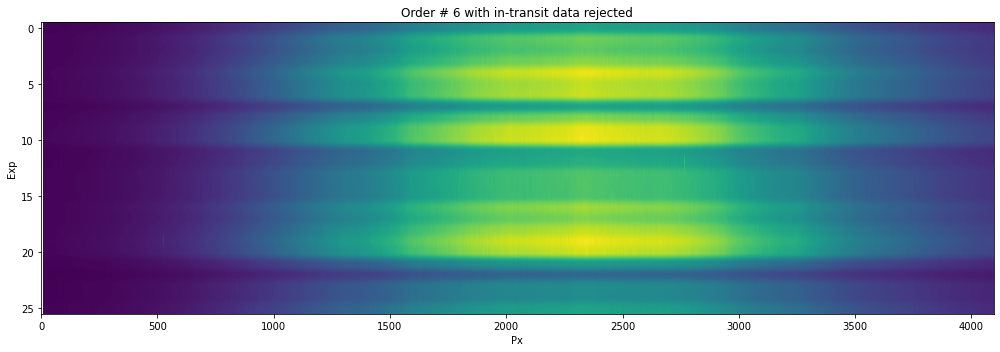

387.5177497257599 415.68117657048697


In [6]:
order_start = 0
order_end = 10

min_wl = np.inf
max_wl = 0


mask = sp.transit(dp)
mask[mask<1]=0

list_of_orders_oot = []
list_of_wls_oot = []
list_of_sigmas_oot = []
for i in range(order_start,np.min([order_end,len(list_of_orders)])):
    list_of_orders_oot.append(list_of_orders_cor[i][mask==1])
    list_of_wls_oot.append(list_of_wls_cor[i])
    list_of_sigmas_oot.append(list_of_sigmas_cor[i][mask==1])
    min_wl = np.min([np.min(list_of_wls_cor[i]),min_wl])
    max_wl = np.max([np.max(list_of_wls_cor[i]),max_wl])
        
list_of_wld = copy.deepcopy(list_of_wls_oot)
        
plt.figure(figsize=(14,5))
plt.imshow(list_of_orders_oot[oi],aspect='auto')
plt.title(f'Order # {oi} with in-transit data rejected')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

n_exp = len(list_of_orders_oot[0])
phase = np.linspace(-0.05,0.05,n_exp)#This will be used later to shift the model.

print(min_wl,max_wl)

We will now make an intermediate wavelength array on which the opacity functions will live. This is both to throw away unnecessary opacity values to make things more nimble, and to define opacity on a constant-dv grid, which will aide in convolution.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


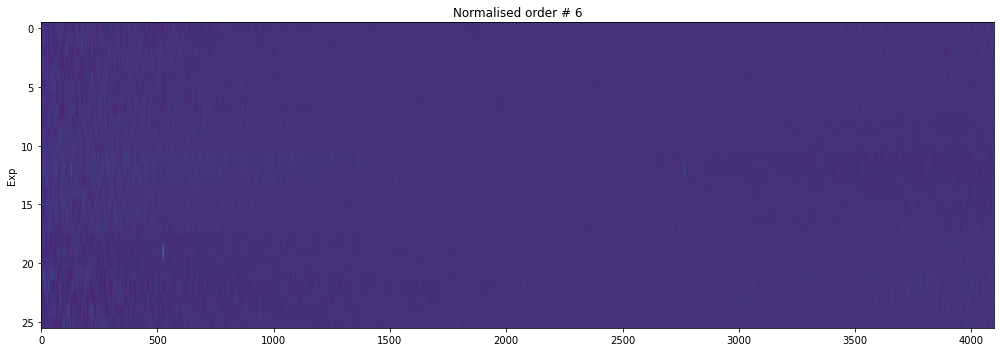

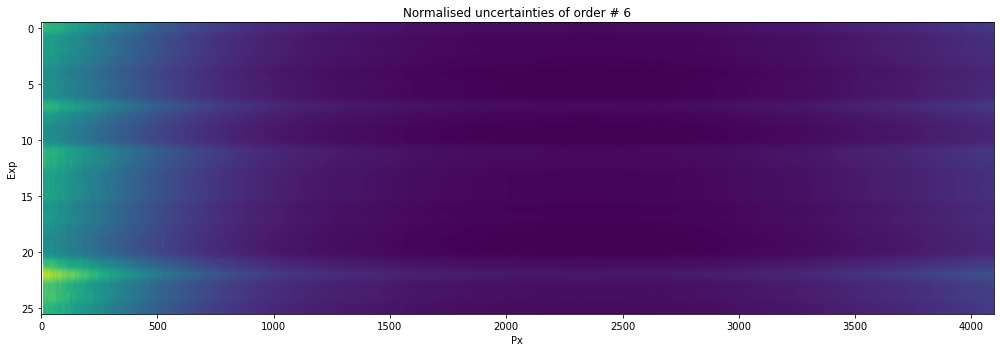

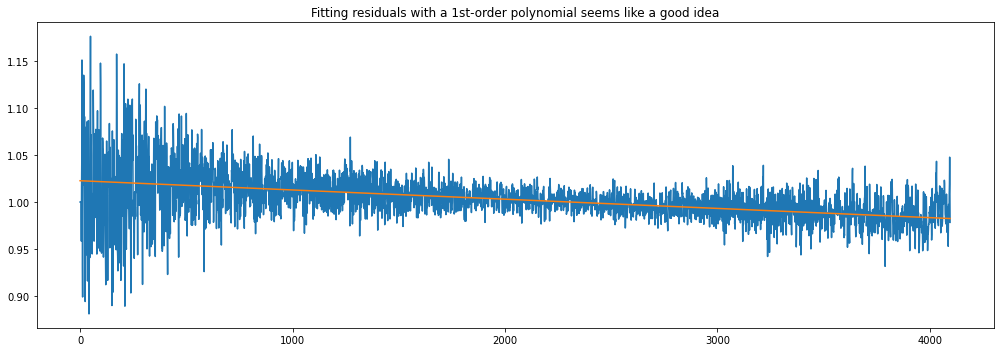

In [7]:

meanfluxes = []#These are the time-dependent average fluxes that we divide out of each order.
meanspecs = []#These are the average spectra that we divide out of each order.
list_of_res = []
list_of_res_e = []

for i in range(len(list_of_orders_oot)):
    order = list_of_orders_oot[i]
    sigma = list_of_sigmas_oot[i]
    meanflux = np.nanmean(order,axis=1)
    meanfluxes.append(meanflux)
    order_norm = (order.T/meanflux).T
    sigma_norm = (sigma.T/meanflux).T
    meanspec = np.nanmean(order_norm,axis=0)
    meanspecs.append(meanspec)
    
    order_clean = order_norm/meanspec
    sigma_clean = sigma_norm/meanspec
    
    #I'm also going to set NaNs to 1.0 and then set sigma to infinite there.
    sigma_clean[np.isfinite(order_clean)==False]=np.inf
    order_clean[np.isfinite(order_clean)==False]=1.0
    
    list_of_res.append(order_clean)
    list_of_res_e.append(sigma_clean)
    
    

    
plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi],aspect='auto')
plt.title(f'Normalised order # {oi}')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()
    
plt.figure(figsize=(14,5))
plt.imshow(list_of_res_e[oi],aspect='auto')
plt.title(f'Normalised uncertainties of order # {oi}')
plt.xlabel('Px')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()


expfit = 11
xfit = np.arange(len(list_of_res[oi][expfit]))
fit = np.polyfit(xfit, list_of_res[oi][expfit], 1,w = 1/list_of_res_e[oi][expfit])
plt.figure(figsize=(14,5))
plt.plot(xfit,list_of_res[oi][expfit])
plt.plot(xfit,np.poly1d(fit)(xfit))   
plt.title('Fitting residuals with a 1st-order polynomial seems like a good idea')
plt.tight_layout()
plt.show()

So this data has a skewed continuum. In the ideal world, a slope in the continuum should be part of the model that I am going to fit. But this will generate at least 2 new free parameters (1st degree polynomial) for each exposure in each order. For 70 orders and 30 exposures, this would be over 4000 new free parameters. I do expect that this could  lead to a system of equations that can be solved in the mcmc because all these free parameters are very much decoupled from the physical parameters of the atmosphere (save the continuum degeneracy that's already there), but I'm not going to tackle that problem for the moment. Instead, we fit these separately and save the filter, supply that to the model and filter the model in the same way. This is equivalent to the strategy of Gibson et al. 2022. This is expected to bias the best-fit model somewhat, but I suspect that for spectral features much smaller than the systematic slopes introduced by the instrument, such biases should be small compared to the line depths themselves. Let's proceed with the filtering:

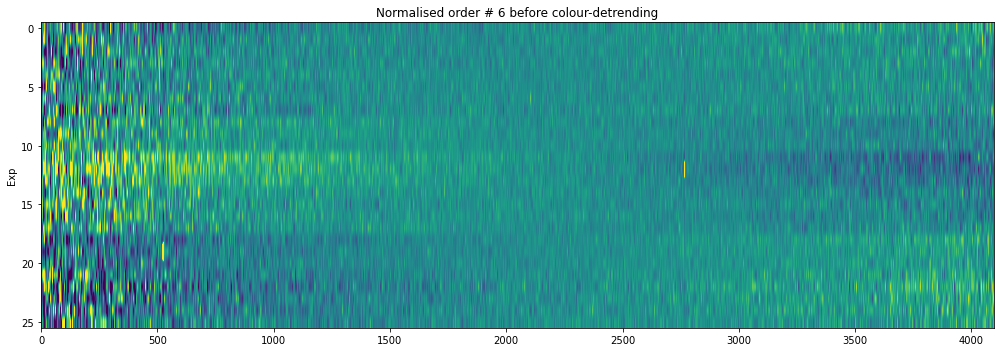

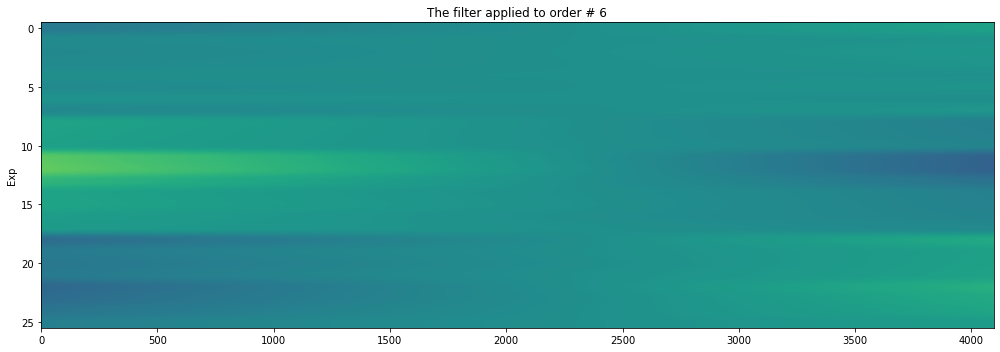

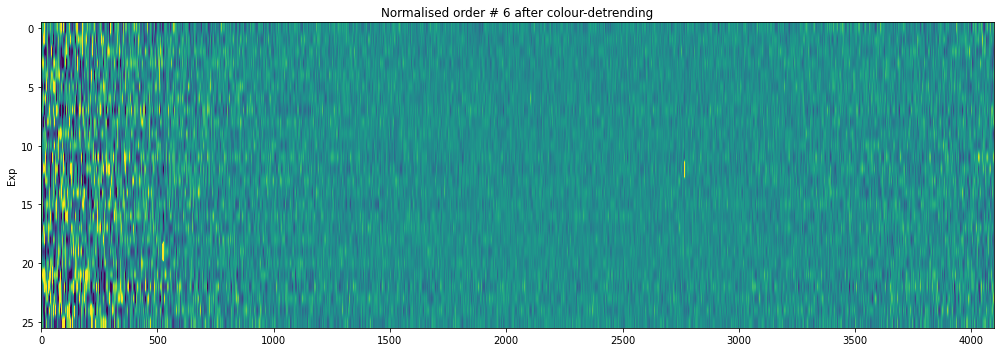

In [8]:
list_of_filters = []
list_of_res_clean = []
list_of_res_clean_e = []
deg = 1
for i in range(len(list_of_res)):
    order = list_of_res[i]
    xfit = np.arange(len(order[0]))
    polyfilter = order*0.0
    fit2d = np.polyfit(xfit,order.T,deg).T

    for j in range(len(order)):
        polyfilter[j] = np.poly1d(fit2d[j])(xfit)
    list_of_filters.append(polyfilter) 
    list_of_res_clean.append(list_of_res[i]/polyfilter)
    list_of_res_clean_e.append(list_of_res_e[i]/polyfilter)
        
stdev = np.nanmedian(list_of_res_e[oi])
plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'Normalised order # {oi} before colour-detrending')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'The filter applied to order # {oi}')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(list_of_res[oi]/list_of_filters[oi],aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'Normalised order # {oi} after colour-detrending')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()




Buried in this noise is the transmission spectrum, in units of transit radius, which is our primary observable to which we will fit a model. We will now need to make this model, applicable to 2D data, and this filter needs to be applied to the model to account for the change in line depth due to the division of that slope. Because the data is now de-trended and the mean is 1.0 per definition, I will now h-stack the data, the uncertainties and the filters. This will make handling the whole dataset a lot easier.<br><br>

Anyway, to apply the filter, I will not divide it out of the data. Instead, I will save these and multiply them against the model.

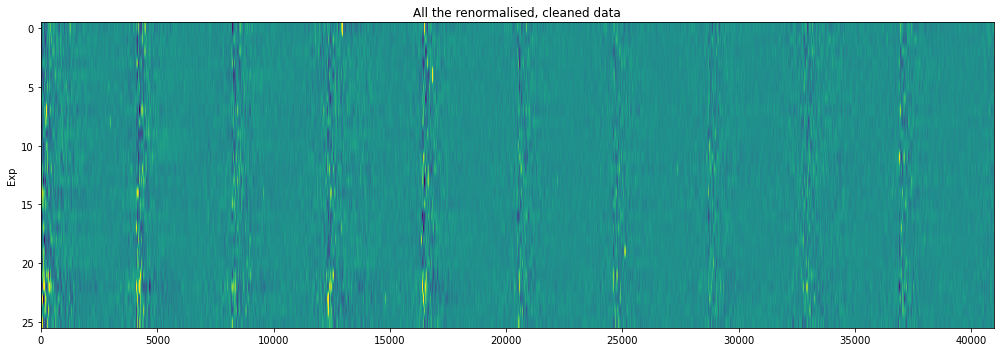

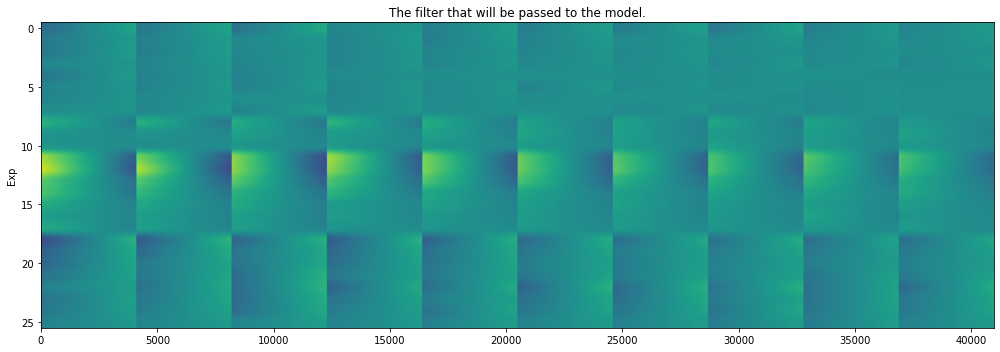

In [187]:
fxd = np.hstack(list_of_res_clean) #This is the data.
err = np.hstack(list_of_res_clean_e)#This is the uncertainty
fxf = np.hstack(list_of_filters)#This is the filter
wld = np.hstack(list_of_wld)#This is the wavelength axis.

plt.figure(figsize=(14,5))
plt.imshow(fxd,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'All the renormalised, cleaned data')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

plt.figure(figsize=(14,5))
plt.imshow(fxf,aspect='auto',vmin=1-3*stdev,vmax=1+3*stdev)
plt.title(f'The filter that will be passed to the model.')
plt.ylabel('Exp')
plt.tight_layout()
plt.show()

Interestingly, the filters all have a very correlated shape from order to order. I think that this makes sense, because colour-variation probably depends on the local shape of the SED, which is very similar order to order. Maybe I can leverage this during the retrieval to make that system of equations smaller? Maybe the polynomial coefficient of each exposure in each order can be related to the coefficients of the other orders via a polynomial themselves? If that's a low order polynomial, the number of free parameters would be a few times the number of exposures; rather than the number of orders times the number of exposures... Not sure that this will generalise though... Perhaps a GP?

Anyway, we now proceed with making the model. The first thing that we're going to do is to prepare the opacities, to convert them to a new wavelength grid that will allow us to blur the resulting transmission spectrum.

In [10]:
#We are going to bracket the minimum and maximum wavelengths of the intermediate wavelength array by 500 km/s in velocity.
doppler_factor = (500*u.km/u.s / const.c).decompose().value
min_wl*=(1-doppler_factor)
max_wl*=(1+doppler_factor)


for i in list(S.keys()):
    wli,kappa_i,dv = ops.constant_velocity_wl_grid(np.array(k_wl[1:]),np.array(S[i].kappa[1:]),
                                                       oversampling=1.0,minmax=[min_wl,max_wl]) # The intermediate wavelength grid.
                                                        #Index it from 1 onwards because the first value is np.inf.
#     S[i].kappa_i = jnp.array(kappa_i)
    S[i].kappa_i = copy.deepcopy(kappa_i)

So now we have opacity functions interpolated onto a fine-grained constant-dv grid.
The next task is to make a model that matches the order-wise data. This is tricky because each order has its own continuum normalization, so the number of free parameters may be mad.

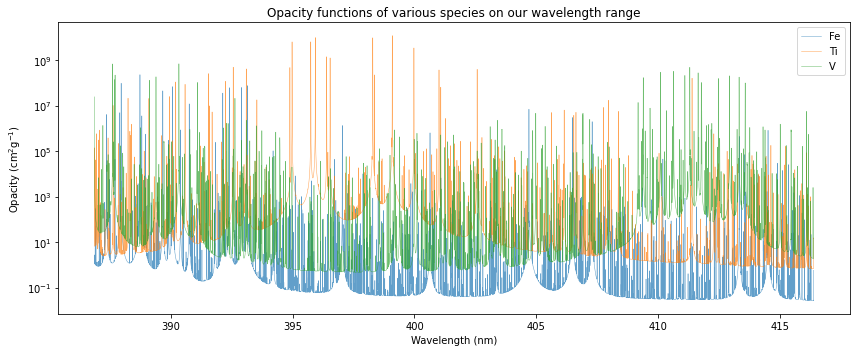

In [11]:

plt.figure(figsize=(12,5))

for i in list(S.keys()):
    plt.plot(wli,S[i].kappa_i,label=i,linewidth=0.5,alpha=0.7)
plt.yscale('log')
plt.xlabel('Wavelength (nm)')
plt.title("Opacity functions of various species on our wavelength range")
plt.ylabel('Opacity (cm$^2$g$^{-1}$)')
plt.legend()
plt.tight_layout()
plt.show()

### Defining the planet

In [12]:
gamma = 0.57721
RJ = const.R_jup.cgs.value
MJ = const.M_jup.cgs.value
G = const.G.cgs.value
Rsun = const.R_sun.cgs.value

P0 = (1.0*u.bar).cgs.value#bar
R0 = 1.8*RJ
M0 = 1.2*MJ
k = const.k_B.cgs.value
m = 2.33*const.u.cgs.value
Rs = 1.4*Rsun
g = G*M0 / R0**2





### The order-by-order model

Let's specify the model that we will fit to the data using the numpy module within jax. We'll also "decorate" it with the `jit` decorator, which will compile the function for us at runtime. 

This model is complicated for three reasons.<br>
First of all, because there is a variety of species. Each of these has their own opacity function and abundance. I set it up such that the first species provided is Fe, and all the other species are then measured relative to Fe.<br>
Secondly, the model needs to be broadened and shifted. This adds more free parameters, and a convolution operation.<br>
Thirdly, the data is 2D, meaning that the number of datapoints is massive.<br><br><br><br>
The smart way to solve the first issue, is to keep the chosen opacities general. So unlike the previous notebook where the species were hardcoded, we now choose to pass the opacity functions as a matrix, ordered such that the first row is the Fe opacity, and the remaining rows are opacity functions which correspond to the order of the abundances relative to Fe, as supplied in the parameter `p` which encodes the free parameters.

We define the model in two flavours. The first is the numpy model, which is expected to be slow. The second is the just-in-time compiled model, and we'll compare the performance of the two.

In [13]:
def model_numpy(p,wl,kappa_grid,filters):
    #First we unpack our free parameters:
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c0-R**2 / Rs**2)


@jit
def model_jax(p,wl,kappa_grid,filters):
    #This model is the exact same as above, just with the jit decorator.
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1])
    logk0 = p[n_species+1]
    c0 = p[n_species+2]
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c0-R**2 / Rs**2)

In [14]:
kappa_grid = np.vstack([S['Fe'].kappa_i,S['Ti'].kappa_i,S['V'].kappa_i])
n_species = len(kappa_grid)#The first species should be Fe.


p = [2500.0,-5.0,-1.0,-2.0,-2.0,1.0]# The model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0.

#The timed comparison:
N=300

t1=ut.start()
for i in range(N):
    model_numpy(p,wld,kappa_grid,fxf)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per numpy model: {np.round(t2*1000,3)} ms')


t1=ut.start()
for i in range(N):
    model_jax(p,wld,kappa_grid,fxf)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per jax model: {np.round(t2*1000,3)} ms')

Elapsed time per numpy model: 6.607 ms
Elapsed time per jax model: 1.932 ms


If all went well, the jax model is significantly faster (about 3 to 4 times) than numpy. That's great!
<br><br><br>
However, when developing this, I realised that this is drop-in type addition of just-in-time compilation is only the beginning. In JAX, there is a difference between static and traced variables. Traced variables can be seen as the free parameters of a function. Static variables are the constants. <br><br>
For example, the function f(x)=a*x + b is commonly understood to have one free parameter and two coefficeints. We could code that up as `def f(x,a,b):...`. However to python and JAX, x, a and b would all be equally free parameters.<br><br>
Instead, if a parameter is really <b>not</b> free (for example because they are natural constants that are always the same, no matter in what situation the function is called), they could be hard-coded when the function is compiled. These are <i>static</i> variables in JAX, and it turns out that reducing the number of free function parameters has the potential to make our compiled code faster (see relevant docs [here](https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html)).<br><br><br>
For our problem, this may be significant because you can consider the opacity functions of atoms to be natural constants. In fact, the model that we're fitting to the data has a small number of physical free parameters (temperature, abundances), but many things are fixed, meaning that they don't change while the MCMC sampler is traversing likelihood space. That includes the opacities, but also the wavelength grid of the data (which is needed to interpolate onto), some system parameters (g, P0, R0), and the de-trending filter.<br><br><br>
Unfortunately, one issue with static variables is that they are not allowed to be numpy arrays or lists. So, I decided to convert these big 2D matrices to flat byte arrays, which are hashable. Then, I pass the dimensions of these arrays as additional function parameters. Inside the function, these byte arrays will be converted back to numpy arrays, and used in the remainder of the calculation.

In [15]:
@partial(jit, static_argnums=(1,2,3,4,5,6,7,8,9,10,11,12,13))
def model_jax_adv(p,wl_B,kappa_grid_B,filters_B,k,m,g,P0,R0,Rs2,nwli,nwld,nexp,n_species):
    """
    This is a model of the transmission spectrum following H&K17 with a number of absorbing species. The abundances 
    of absorbing species are expressed relative to iron. The opacities of these species are supplied in a flat byte
    array, so that it can be compiled by jax as a static variable (scary, I know...).
    The same is true for the wavelength grid of the data (wl), and the filter function, which both ordinarily have
    shapes commesurate with the data to which this model will be compared. The result of this function is hence a 2D
    spectroscopic time-series. To reshape these flat byte arrays back to their original forms, we now need to pass
    these data dimensions to the function as well.
    
    The free parameters of the spectrum of a planet with certain fixed parameters (m, g, P0, R0, Rs) are
    encoded in the list p in the following order:
    
    -The isothermal temperature in K.
    -The logarithm of the Fe abundance.
    -The logarithms of the ratios of each species relative to Fe.
    -The logarithm of the gray opacity.
    -A constant offset of the model spectrum.
    
    
    """
    wl = np.frombuffer(wl_B)
    kappa_grid = np.reshape(np.frombuffer(kappa_grid_B),(n_species,nwli))
    filters = np.reshape(np.frombuffer(filters_B),(nexp,nwld))
    
    
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering.    
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    H = k*T/m/g
    
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    return (c0-R**2 / Rs2)

In [48]:
nwli = len(wli)
nwld = len(wld)
nexp = len(fxf)
wld_b = wld.tobytes()
kappa_grid_b = kappa_grid.tobytes()
fxf_b = fxf.tobytes()
wli_b = wli.tobytes() #This is used later than the others; when the spectrum needs to be shifted & interpolated.
phase_b = phase.tobytes()

t1=ut.start()
for i in range(N):
    model_jax_adv(p,wld_b,kappa_grid_b,fxf_b,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per model: {np.round(t2*1000,3)} ms')

Elapsed time per model: 1.805 ms


This little ndarray-to-bytes-back-to-ndarray trick combined with the jit decorator has given us a speed increase that's about 3x times that before, and so by now we are more than 10x faster than ordinary numpy.
<br><br>
One thing to note is that when running the above cell again, the speed appears to decrease. Re-running the cell probably entails a re-compilation of the function. Getting the speed back up requires that you re-run the preceding cell as well. So this is like a rifle with a single shot.
<br><br><br>
This is great, but we still have a lot of work to do. Importantly, the spectrum needs to be convolved to take into account the line-spread function, and it needs to be interpolated onto the data's wavelength array. Let's work on those two problems next.
<br><br>
By the way, a very interesting question is <b>what</b> should actually be convolved. The spectrum? The transit radius? Or even the opacity function? In theory, it depends on when various effects are happening. Velocity broadening due to the motion of particles in the atmosphere (or the atmosphere as a whole), may need to be modelled as a convolution of the opacity function itself. However, the effect of the line-spread function of the spectrograph is something that happens to the spectrum that enters the telescope. A model that simply broadens the transit radius or the transmission spectrum is probably too simple! But for now, we'll use this...

In [17]:
def model_conv_numpy(p,wl,kappa_grid,filters,x_kernel):
    #First we unpack our free parameters:
    n_species = len(kappa_grid)
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    
    RT = c0-R**2 / Rs**2
    
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2) #/ ( lw*jnp.sqrt(2*np.pi) )
#     plt.plot(x_kernel,kernel)
#     plt.show() #Looking good.
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    return (RT_b)

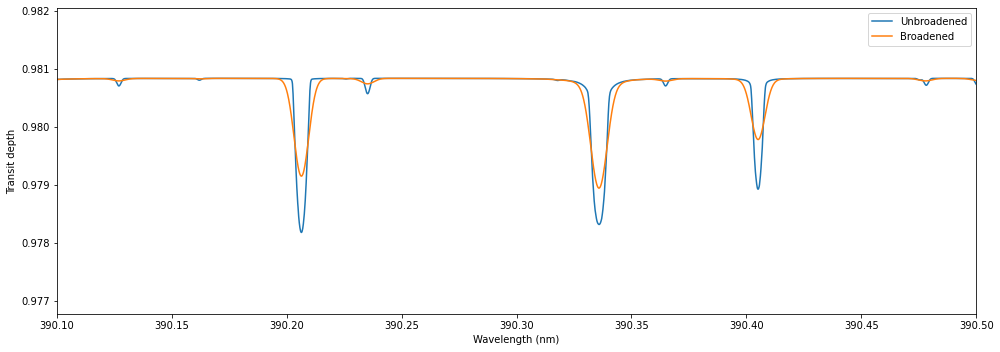

Elapsed time per numpy model: 117.738 ms


In [18]:
sfwhm = 2*np.sqrt(2*np.log(2))#2.355...

p = [2500.0,-5.0,-1.0,-2.0,-2.0,1.0,4.7/sfwhm]# The model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0 and now also the gaussian FWHM line width.


#We first calculate what we want for the convolution kernel.
mf=5.0#max_fwhm_expected
nf=4.0#How many times wider the kernel is compared to the fwhm of the lsf?
k_size = int(mf/dv*nf)
if k_size%2 == 0: k_size+=1#Make sure that it is odd.
x_kernel = (np.arange(k_size)-(k_size-1)/2)*dv #This places 0 directly in the middle; and serves as the x axis of our convolution. On-the-fly, this will be used to calculate a gaussian with which to convolve.


fx = model_numpy(p,wld,kappa_grid,fxf)
fx_b = model_conv_numpy(p,wld,kappa_grid,fxf,x_kernel)


yrange = np.max(fx)-np.min(fx)
plt.figure(figsize=(14,5))
plt.plot(wli,fx,label='Unbroadened')
plt.plot(wli,fx_b,label='Broadened')
plt.legend()
plt.xlim(390.1,390.5)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Transit depth')
plt.ylim(np.max(fx)-yrange,np.max(fx)+0.3*yrange)
plt.tight_layout()
plt.show()

N=20#We need to decrease the number here, because convolution is slow.
t1=ut.start()
for i in range(N):
    model_conv_numpy(p,wld,kappa_grid,fxf,x_kernel)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per numpy model: {np.round(t2*1000,3)} ms')

So this convolution has made things some 20x slower. Lets see how that is with jax. Now I'm going to pass this kernel as a static byte array directly.

In [203]:
@partial(jit, static_argnums=(1,2,3,4,5,6,7,8,9,10,11,12,13,14))
def model_conv_jax(p,wl_B,kappa_grid_B,filters_B,x_kernel_B,k,m,g,P0,R0,Rs2,nwli,nwld,nexp,n_species):
    wl = np.frombuffer(wl_B)
    kappa_grid = np.reshape(np.frombuffer(kappa_grid_B),(n_species,nwli))
    filters = np.reshape(np.frombuffer(filters_B),(nexp,nwld))
    x_kernel = np.frombuffer(x_kernel_B)
    
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    
    RT = c0-R**2 / Rs**2
    
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2) #/ ( lw*jnp.sqrt(2*np.pi) )
#     plt.plot(x_kernel,kernel)
#     plt.show() #Looking good.
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    #I explicitly divide by the sum of the kernel instead of doing the analytical normalisation above, 
    #to deal with cases that the kernel is so wide that it starts going over the edge, reducing the integrated
    #area.
    
    return (RT_b)

In [204]:
x_kernel_b = x_kernel.tobytes()
t1=ut.start()
N=50
for i in range(N):
    model_conv_jax(p,wld_b,kappa_grid_b,fxf_b,x_kernel_b,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per model: {np.round(t2*1000,3)} ms')


Elapsed time per model: 63.164 ms


This seems to be a factor of about 2x faster than numpy. It looks like the convolution dominates our calculation time.
It may be possible to express this convolution as a matrix operation in a smart way later, but for now we'll stick with this. ~50ms for a velocity-broadened model is still very good, because running thousands of models is still very tractable.<br><br><br>
The next step is to interpolate this model onto the grid of the data. That goes in two dimensions, and requires the keplerian of the orbit, derived from the orbital phase. We first show how this works outside of the jax function, and then implement it.<br><br>
Note that the data wavelength array contains breaks and overlaps. This is not a concern for the interpolation, though, because `jnp.interp()` requires the 1D spectrum to have monotonically increasing values. The interpolates can be freely chosen. Also note that we do not care about edge effects here. We had chosen the model to be wider than the data, so the interpolated 2D time-series will not have crossed the boundaries of the model.<br><br>
Finally, in the final row; in the return statement, we divide the mean flux out of the model and multiply the filter (i.e. the measured continuum shape of the data) in. This division is <b>almost</b> equal to what we have done to the data, namely order-by-order renormalisation. The continuum is a part of the model that is needed to reproduce the data as it is.

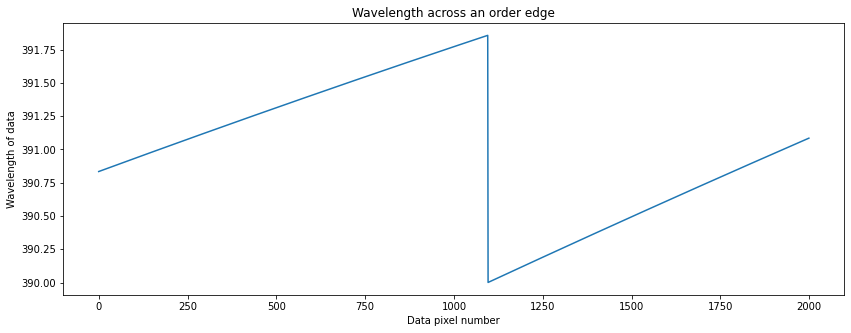

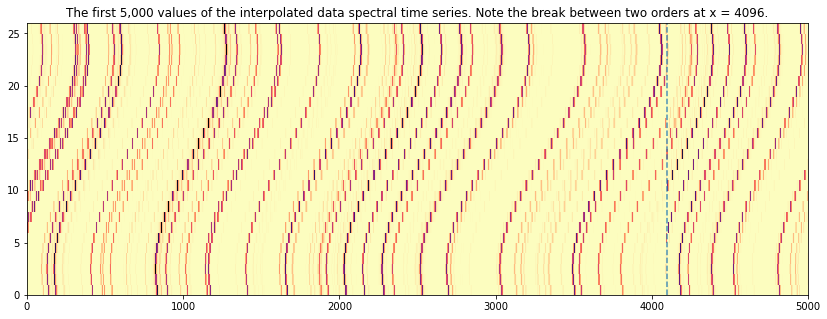

In [295]:
c = const.c.to('km/s').value
Kp = 200.0#Some test variables.
vsys = 20.0

phase_test = phase*6#We artificially increase the phase here to make the sinusoid of the orbit visible.

rvp = jnp.sin(phase_test*2*np.pi)*Kp + vsys#The equation of a circle.
df = 1-rvp/c#The doppler factor associated with these velocities. There is a minus sign here because of the direction of the interpolation.

shifted_wld = jnp.outer(df,wld)#This is a big 2D matrix with shape n_phase x n_wld. So that is as large as the data.





spec = model_conv_jax(p,wld_b,kappa_grid_b,fxf_b,x_kernel_b,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
spec2D = np.interp(shifted_wld,wli,spec)


plt.figure(figsize=(14,5))
plt.plot(wld[3000:5000])
plt.xlabel('Data pixel number')
plt.ylabel('Wavelength of data')
plt.title('Wavelength across an order edge')
plt.show()
plt.figure(figsize=(14,5))
plt.pcolormesh(spec2D[:,0:5000],shading='auto',cmap='magma')
plt.title('The first 5,000 values of the interpolated data spectral time series. Note the break between two orders at x = 4096.')
plt.axvline(4096,linestyle='--',alpha=0.8)
plt.show()

In [296]:
@partial(jit, static_argnums=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18))
def model_2D_jax(p,wl_B,wlk_B,kappa_grid_B,filters_B,phase_B,x_kernel_B,c,gamma,k,m,g,P0,R0,Rs2,nwli,nwld,nexp,n_species):
    wl = np.frombuffer(wl_B)
    wlk = np.frombuffer(wlk_B)#The wavelengths of the opacity grid.
    kappa_grid = np.reshape(np.frombuffer(kappa_grid_B),(n_species,nwli))
    filters = np.reshape(np.frombuffer(filters_B),(nexp,nwld))
    x_kernel = np.frombuffer(x_kernel_B)
    phase = np.frombuffer(phase_B)
    
    
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    vsys = p[n_species+4]
    Kp = p[n_species+5]

    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    RT = c0-R**2 / Rs**2
    
    #Then we convolve:
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2)
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    
    #Then we populate the 2D time series:
    rvp = jnp.sin(phase*2*np.pi)*Kp + vsys #Radial velocity of the planet as a function of the orbital phase.
    shifted_wl = jnp.outer(1-rvp/c,wl)#This populates a 2D matrix containing a row of shifted wavelengths for each of the spectra.
    
    spec2D = jnp.interp(shifted_wl,wlk,RT_b)
    
    return ((spec2D.T/jnp.mean(spec2D,axis=1)).T*filters)

Elapsed time per JAX model: 75.556 ms
done


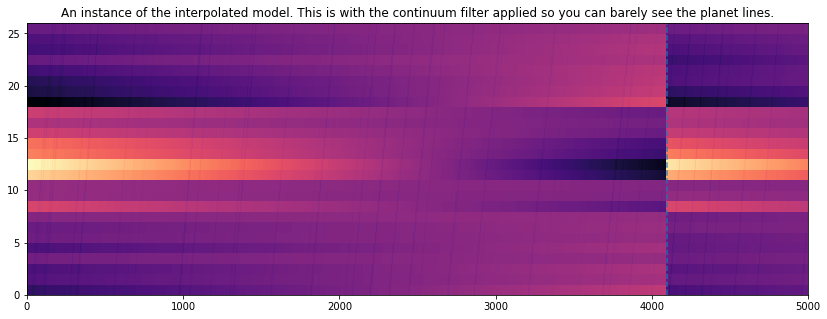

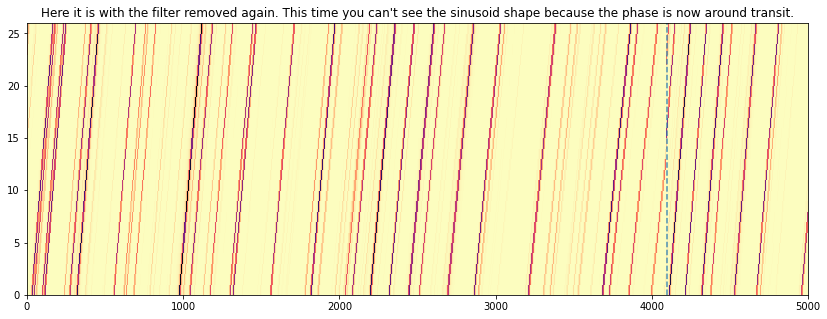

In [297]:
p = [2500.0,-5.0,-1.0,-2.0,-2.0,1.0,4.7/sfwhm,vsys,Kp]# The new model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0, lw, and now also vsys and Kp.


N=50
t1=ut.start()
for i in range(N):
    spec2D = model_2D_jax(p,wld_b,wli_b,kappa_grid_b,fxf_b,phase_b,x_kernel_b,c,gamma,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per JAX model: {np.round(t2*1000,3)} ms')


spec2D = model_2D_jax(p,wld_b,wli_b,kappa_grid_b,fxf_b,phase_b,x_kernel_b,c,gamma,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
print('done')
plt.figure(figsize=(14,5))
plt.pcolormesh(spec2D[:,0:5000],shading='auto',cmap='magma')
plt.title("An instance of the interpolated model. This is with the continuum filter applied so you can barely see the planet lines.")
plt.axvline(4096,linestyle='--',alpha=0.8)
plt.show()
plt.figure(figsize=(14,5))
plt.pcolormesh((spec2D/fxf)[:,0:5000],shading='auto',cmap='magma')
plt.title("Here it is with the filter removed again. This time you can't see the sinusoid shape because the phase is now around transit.")
plt.axvline(4096,linestyle='--',alpha=0.8)
plt.show()

<b> For some reason The execution time of this cell is very variable. Sometimes it evaluates the model in more than 100ms, sometimes in less than 1ms. But most often it's between 60 and 80ms. Is my computer doing stuff in the background? Is there an issue with garbage collection? Memory leak?</b><br><br>We also make a numpy version of this and then compare the computation speed.

In [298]:
def model_2D_numpy(p,wl,wlk,kappa_grid,filters,phase,x_kernel,c,gamma,k,m,g,P0,R0,Rs2,nwli,nwld,nexp,n_species):    
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    vsys = p[n_species+4]
    Kp = p[n_species+5]

    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+np.log(P0 * K / g * np.sqrt(2*np.pi*R0/H) ) )
    RT = c0-R**2 / Rs**2
    
    #Then we convolve:
    kernel = np.exp(-0.5 * x_kernel**2 / lw**2)
    RT_b = np.convolve(RT,kernel/np.sum(kernel),mode='same')
    
    #Then we populate the 2D time series:
    rvp = np.sin(phase*2*np.pi)*Kp + vsys #Radial velocity of the planet as a function of the orbital phase.
    shifted_wl = np.outer(1-rvp/c,wl)#This populates a 2D matrix containing a row of shifted wavelengths for each of the spectra.
    
    spec2D = np.interp(shifted_wl,wlk,RT_b)
    
    return ((spec2D.T/np.mean(spec2D,axis=1)).T**filters)




t1=ut.start()
for i in range(N):
    spec2D = model_2D_numpy(p,wld,wli,kappa_grid,fxf,phase,x_kernel,c,gamma,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per numpy model: {np.round(t2*1000,3)} ms')

Elapsed time per numpy model: 76.799 ms


And we also do it without static variables:

In [299]:
@jit
def model_2D_jax_traced(p,wl,wlk,kappa_grid,filters,phase,x_kernel,c,gamma,k,m,g,P0,R0,Rs2,nwli,nwld,nexp):
    n_species = 3
    T = p[0]
    chi_fe = 10**p[1]
    logratios = jnp.array(p[2:n_species+1]) #Add a zero for Fe itself. Is this going to mess up autodif?
    logk0 = p[n_species+1]
    c0 = p[n_species+2] #Constant offset to ensure continuum-degeneracy despite filtering. 
    lw = p[n_species+3]
    vsys = p[n_species+4]
    Kp = p[n_species+5]

    
    #Then we compute kappa:
    chi_i = chi_fe * 10 ** logratios 
    K = chi_fe * kappa_grid[0] + jnp.dot(chi_i,kappa_grid[1:]) + 10**logk0
    
    #Then we do the magic:
    H = k*T/m/g
    R = R0 + H*(gamma+jnp.log(P0 * K / g * jnp.sqrt(2*np.pi*R0/H) ) )
    RT = c0-R**2 / Rs**2
    
    #Then we convolve:
    kernel = jnp.exp(-0.5 * x_kernel**2 / lw**2)
    RT_b = jnp.convolve(RT,kernel/jnp.sum(kernel),mode='same')
    
    #Then we populate the 2D time series:
    rvp = jnp.sin(phase*2*np.pi)*Kp + vsys #Radial velocity of the planet as a function of the orbital phase.
    shifted_wl = jnp.outer(1-rvp/c,wl)#This populates a 2D matrix containing a row of shifted wavelengths for each of the spectra.
    
    spec2D = jnp.interp(shifted_wl,wlk,RT_b)
#     return(RT_b)
    return ((spec2D.T/jnp.mean(spec2D,axis=1)).T*filters)

In [300]:
t1=ut.start()
for i in range(N):
    spec2D = model_2D_jax_traced(p,wld,wli,kappa_grid,fxf,phase,x_kernel,c,gamma,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp)
t2 = ut.end(t1,silent=True)/N
print(f'Elapsed time per JAX traced model: {np.round(t2*1000,3)} ms')

Elapsed time per JAX traced model: 75.95 ms


So it looks like the two implementations of JAX are more or less equivalent in run-time, due to the fact that we have now added this sequence of massive matrix operations. Surprisingly, the numpy implementation is slightly faster. Nevertheless we still need the JAX implementation to make use of the autodifferentiation, as well as GPU's later.

Ok...! So now it's time to apply the MCMC, which we do as before. But first we make a real instance of the model injected into the data.

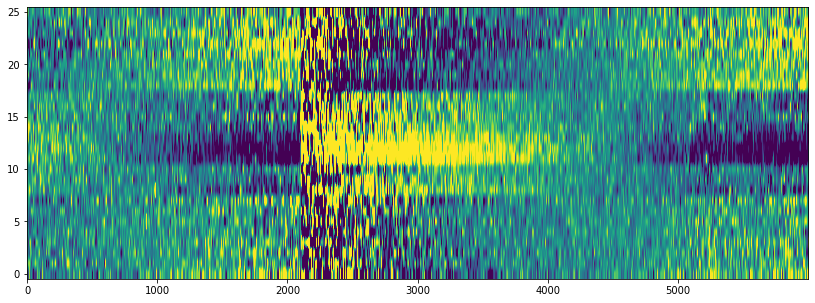

In [322]:
# fxd = np.hstack(list_of_res_clean) #This is the data.
# err = np.hstack(list_of_res_clean_e)#This is the uncertainty
# fxf = np.hstack(list_of_filters)#This is the filter
# wld = np.hstack(list_of_wld)#This is the wavelength axis.

true_p = [2500.0,-5.0,-1.0,-2.0,-2.0,1.0,8.0/sfwhm,20.0,149.0]# The new model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0, lw, and now also vsys and Kp.

true_2D_model = model_2D_jax(true_p,wld_b,wli_b,kappa_grid_b,fxf_b,phase_b,x_kernel_b,c,gamma,k,m,g,P0,R0,Rs**2,nwli,nwld,nexp,n_species)

DATA = fxd*true_2D_model #This has the filter multiplied back in.
DATA_E = err*true_2D_model
plt.figure(figsize=(14,5))
plt.imshow(DATA[:,2000:8000],origin='lower',aspect='auto',vmin=np.mean(DATA)-3*yrange,vmax=np.mean(DATA)+3*yrange)

This multiplication of data with filter-added model, basically means that I have assumed that the out-of-transit data was divided out cleanly, i.e. that dividing with the mean spectrum did not affect the model spectrum. 

In [323]:

#p_real = [2500.0,-5.0,-1.0,-2.0,-2.0,1.0,8.0/sfwhm,20.0,149.0]# The new model parameters: T, Fe, 2 other species relative to Fe, log(k0), c0, lw, and now also vsys and Kp.

def numpyro_model():
    """
    Define a model to sample with the No U-Turn Sampler (NUTS) via numpyro.
    
    The two Gaussians are defined by an amplitude, mean, and standard deviation.
    
    To find unique solutions for the two Gaussians, we put non-overlapping bounded 
    priors on the two amplitudes, but vary the means and stddev's with identical 
    uniform priors. 
    """
    # Define a prior for the temperature:
    T_prior = numpyro.sample('T', dist.Uniform(low=1000, high=6000))
    
    # Uniform prior for log(chi_fe)
    chi_fe_prior = numpyro.sample(
        'log($\chi_{Fe}$)', dist.Uniform(low=-10, high=-3))
 
    chi_ratio_priors = []
    for i in range(len(labels)):
        chi_ratio_priors.append(numpyro.sample('log($\chi_{'+labels[i]+'}$ / $\chi_{Fe}$)', dist.Uniform(low=-10, high=2)))
        

    
    # Uniform prior for log(k0):
    k0_prior = numpyro.sample('log($\kappa_0$)', dist.Uniform(low=-5, high=0))

#     Uniform prior for log(k0):
#     c_prior = numpyro.sample('c', dist.Normal(loc=1.0, scale=0.001))
    c_prior = numpyro.sample('c0', dist.Uniform(low=0.995, high=1.005))
    
    lw_prior = numpyro.sample('lw', dist.Uniform(low=3/sfwhm, high=20/sfwhm))
    vsys_prior = numpyro.sample('$v_{sys}$', dist.Uniform(low=10, high=30))
    Kp_prior = numpyro.sample('$K_p$', dist.Uniform(low=130, high=170))
    
    priors = [T_prior,chi_fe_prior]+chi_ratio_priors+[k0_prior,c_prior,lw_prior,vsys_prior,Kp_prior]
    
    # Normally distributed likelihood
    numpyro.sample("obs", dist.Normal(loc=model_2D_jax(priors,wld_b,wli_b,kappa_grid_b,fxf_b,
                                                       phase_b,x_kernel_b,c,gamma,k,m,g,P0,R0,
                                                       Rs**2,nwli,nwld,nexp,n_species).flatten(),
                                      scale=DATA_E.flatten()), obs=DATA.flatten())
                   
                   
                   
                   

In [ ]:
from jax.random import PRNGKey, split
import arviz
from corner import corner
rng_seed = 42
rng_keys = split(PRNGKey(rng_seed),cpu_cores
)

# Define a sampler, using here the No U-Turn Sampler (NUTS)
# with a dense mass matrix:
sampler = NUTS(
    numpyro_model_adv, 
    dense_mass=True
)

# Monte Carlo sampling for a number of steps and parallel chains: 
mcmc = MCMC(
    sampler, 
    num_warmup=100, 
    num_samples=500, 
    num_chains=4
)

# Run the MCMC
mcmc.run(rng_keys)





In [326]:
print(len(true_p))

9


In [ ]:
result = arviz.from_numpyro(mcmc)

# these are the inputs to the synthetic double-gaussian profile (blue lines)
truths = {'T': true_p[0], 
          'log($\chi_{Fe}$)': true_p[1], 
          'log($\chi_{Ti}$ / $\chi_{Fe}$)' : true_p[2],
          'log($\chi_{V}$ / $\chi_{Fe}$)' : true_p[3],
          'log($\kappa_0$)': true_p[4], 
          'c0': true_p[5],
          'lw': true_p[6],
          '$v_{sys}$': true_p[7],
          '$K_p$': true_p[8]
         }

# lw_prior = numpyro.sample('lw', dist.Uniform(low=3/sfwhm, high=20/sfwhm))
# vsys_prior = numpyro.sample('$v_{sys}$', dist.Uniform(low=10, high=30))
# Kp_prior = numpyro.sample('$K_p$', dist.Uniform(low=130, high=170))
# make a corner plot
corner(
    result, 
    quiet=True, 
    truths=truths
);

This is glorious! With an SNR = 200 spectrum (in the blue), you can retrieve abundance ratios in this inflated 2,500 K ultra-hot Jupiter, with an uncertainty of about 0.5 dex, despite the massive pressure-abundance degeneracy.
Of course, there are many questions: What if the data does not have a flat continuum (although it looks flat). What if the data includes species that are not in the model; especially complex species like TiO? Can we apply H&K 2017 in the first place? 
<br><br>
To make progress, the first step is to apply this methodology to a form of real data, with a simulated planet injected into it. This is the topic of the next notebook.